In [1]:
# pip install qiskit qiskit-aer networkx numpy pandas pylatexenc -q

In [2]:
import matplotlib.pyplot as plt
from IPython import display

import networkx as nx
import numpy as np
import pandas as pd
import time

from typing import List
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# The Mischief Makers' Guide to Quantum Puzzles

## Prologue

In the tallest tower of Quantum Academy, five clever wizards gather around a circular table of polished crystal. Sunlight streams through stained glass windows, casting colorful patterns across their excited faces. They chatter animatedly about the intricate web of friendships that hold the kingdom together - bonds as fascinating as they are complex. Today, they will *unravel* these connections (not out of malice, but out of curiosity and the pursuit of knowledge of course!)

For you, the apprentice, this is more than a tale of magical puzzles. It is the path you will walk, step by step, translating their arcane experiments into quantum code. Rest assured: every enchantment is explained well, and code snippets appear only when your understanding requires them.

Good luck!

---

## Chapter I - The Atlas of Connections

*(Graph Construction)*

Before any spell can be cast, the wizards must understand their subject. They unfurl the magnificent Atlas - a parchment map showing every friendship and alliance in the realm. Each name, written in gleaming silver ink, represents a **node**; each silver thread between names, an **edge**.

Below is the actual code that builds one such Atlas: the Cycle Graph of 8 friends.

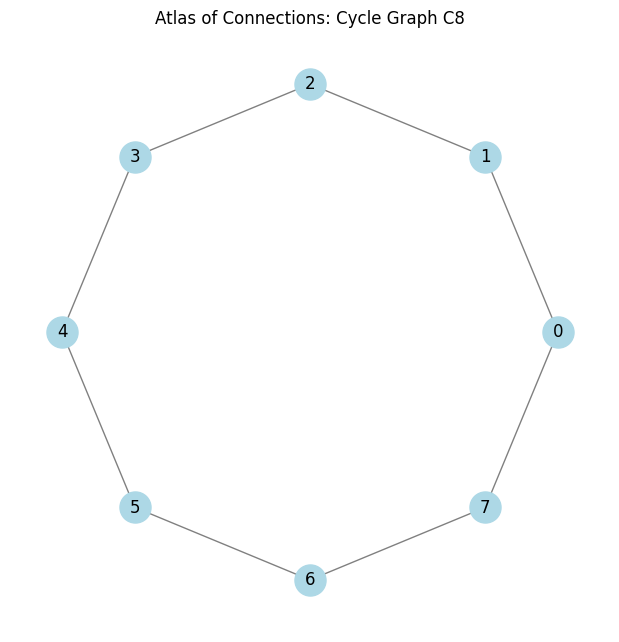

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the Atlas: a cycle graph of 8 friendships

def cycle_graph_c8():
    G = nx.cycle_graph(8)
    plt.figure(figsize=(6, 6))
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True,
            node_color='lightblue', edge_color='gray', node_size=500)
    plt.title("Atlas of Connections: Cycle Graph C8")
    plt.show()
    return G

# Build and display the Atlas
graph = cycle_graph_c8()



---



## Chapter II – Crafting the Puzzle Spell

*(Ansatz Design)*

Once the Atlas lies before them, the Mischief Makers must choose how to explore its secrets. This begins with the ansatz, a parameterized spell that will probe different patterns of friendship. In quantum computing, an ansatz is simply a circuit template with adjustable knobs (parameters) that can prepare a family of quantum states. Think of it as a master recipe: by tuning the spices, you can bake vastly different cakes.

### What is an Ansatz?

The ansatz defines the shape of all possible states we will explore. Instead of checking every configuration (which is infeasible for large networks), we create a flexible circuit whose parameters steer it toward promising patterns Each θ in our circuit is a hidden ingredient—twist it slightly, and the resulting state changes in a predictable way.

### Rotations

Imagine a single qubit as a magical compass that can point in any direction on a sphere. By applying a rotation gate (RY or RZ), we tilt that compass, exploring new directions. In our story we use Whirling Possibilities (RY). A gentle swirl that nudges a friend’s allegiance toward one group or another.

Rather than fix a friend firmly in one camp, rotations allow them to exist in a superposed state—partially here, partially there—until a final measurement decides.

### Entanglement

True mischief requires bonds! Entanglement gates (like CNOT) link pairs of qubits so that their fates become intertwined.We use Connection Ribbons (CNOT). When one friend’s allegiance shifts, its partner is nudged too, reflecting the real-world influence between friends.

Many friendship patterns hinge on how pairs influence each other. Without entanglement, our spell would miss crucial clues about group dynamics.


Below is the *build_ansatz* code, showing how rotations and entanglement combine. Notice how each edge in the Atlas becomes a pair of CNOT gates wrapping a rotation:

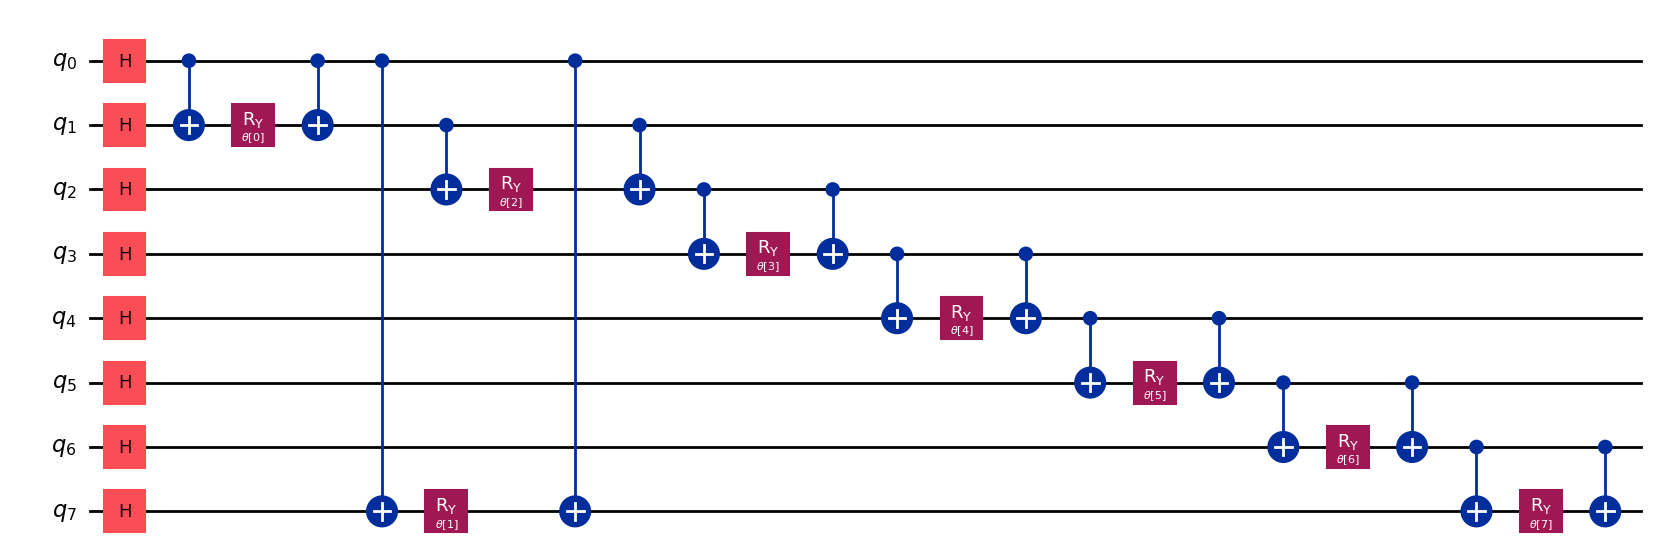

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Build the Puzzle Spell (ansatz)
def build_ansatz(graph: nx.Graph) -> QuantumCircuit:
    ansatz = QuantumCircuit(graph.number_of_nodes())
    ansatz.h(range(graph.number_of_nodes()))  # Initialize superposition

    theta = ParameterVector(r"$\theta$", graph.number_of_edges())
    for t, (u, v) in zip(theta, graph.edges):
        ansatz.cx(u, v)             # Connection Ribbon (entangling)
        ansatz.ry(t, v)            # Whirling Possibility (rotation)
        ansatz.cx(u, v)             # Close the ribbon
    return ansatz

# Create and draw the circuit
ansatz = build_ansatz(graph)
ansatz.draw('mpl', fold=-1)

*Wizard’s Commentary:*

- The initial H gate casts all friends into a balanced doubt, placing each qubit in a superposition of loyalty and dissent.

- For each friendship (edge), the spell:

  1. Opens a Ribbon (CX): Links the two souls.

  2. Swirls Possibilities (RY): Introduces parameter θ to explore new friendship splits.

  3. Seals the Bond (CX): Closes the ribbon, ensuring the entanglement’s effect persists.

Together, these gates craft a rich texture of states. By tuning the θs, our apprentices guide the ansatz toward those states that best reveal the hidden structure of the Atlas. When the time comes, varQITE will update these parameters to sharpen our Puzzle Spell into a precise tool for discovery.



---



## Behind the Scenes: The QITEvolver

Deep in the guild’s hidden archive lies the QITEvolver, a magical contraption that guides our Puzzle Spell through the Wonder Realm. Below is its code, it may look formidable, but every line serves a clear purpose: evolving our parameterized circuit via the variational Quantum Imaginary Time Evolution principle, which we will discuss later.

In [5]:
class QITEvolver:
    """
    A class to evolve a parametrized quantum state under the action of an Ising
    Hamiltonian according to the variational Quantum Imaginary Time Evolution
    (QITE) principle described in IonQ's latest joint paper with ORNL.
    """
    def __init__(self, hamiltonian: SparsePauliOp, ansatz: QuantumCircuit):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz

        # Define some constants
        self.backend = AerSimulator()
        self.num_shots = 10000
        self.energies, self.param_vals, self.runtime = list(), list(), list()

    def evolve(self, num_steps: int, lr: float = 0.4, verbose: bool = True):
        """
        Evolve the variational quantum state encoded by ``self.ansatz`` under
        the action of ``self.hamiltonian`` according to varQITE.
        """
        curr_params = np.zeros(self.ansatz.num_parameters)
        for k in range(num_steps):
            # Get circuits and measure on backend
            iter_qc = self.get_iteration_circuits(curr_params)
            job = self.backend.run(iter_qc, shots=self.num_shots)
            q0 = time.time()
            measurements = job.result().get_counts()
            quantum_exec_time = time.time() - q0

            # Update parameters-- set up defining ODE and step forward
            Gmat, dvec, curr_energy = self.get_defining_ode(measurements)
            dcurr_params = np.linalg.lstsq(Gmat, dvec, rcond=1e-2)[0]
            curr_params += lr * dcurr_params

            # Progress checkpoint!
            if verbose:
                self.print_status(measurements)
            self.energies.append(curr_energy)
            self.param_vals.append(curr_params.copy())
            self.runtime.append(quantum_exec_time)

    def get_defining_ode(self, measurements: List[dict[str, int]]):
        """
        Construct the dynamics matrix and load vector defining the varQITE
        iteration.
        """
        # Load sampled bitstrings and corresponding frequencies into NumPy arrays
        dtype = np.dtype([("states", int, (self.ansatz.num_qubits,)), ("counts", "f")])
        measurements = [np.fromiter(map(lambda kv: (list(kv[0]), kv[1]), res.items()), dtype) for res in measurements]

        # Set up the dynamics matrix by computing the gradient of each Pauli word
        # with respect to each parameter in the ansatz using the parameter-shift rule
        pauli_terms = [SparsePauliOp(op) for op, _ in self.hamiltonian.label_iter() if set(op) != set("I")]
        Gmat = np.zeros((len(pauli_terms), self.ansatz.num_parameters))
        for i, pauli_word in enumerate(pauli_terms):
            for j, jth_pair in enumerate(zip(measurements[1::2], measurements[2::2])):
                for pm, pm_shift in enumerate(jth_pair):
                    Gmat[i, j] += (-1)**pm * expected_energy(pauli_word, pm_shift)

        # Set up the load vector
        curr_energy = expected_energy(self.hamiltonian, measurements[0])
        dvec = np.zeros(len(pauli_terms))
        for i, pauli_word in enumerate(pauli_terms):
            rhs_op_energies = get_ising_energies(pauli_word, measurements[0]["states"])
            rhs_op_energies *= get_ising_energies(self.hamiltonian, measurements[0]["states"]) - curr_energy
            dvec[i] = -np.dot(rhs_op_energies, measurements[0]["counts"]) / self.num_shots
        return Gmat, dvec, curr_energy

    def get_iteration_circuits(self, curr_params: np.array):
        """
        Get the bound circuits that need to be evaluated to step forward
        according to QITE.
        """
        # Use this circuit to estimate your Hamiltonian's expected value
        circuits = [self.ansatz.assign_parameters(curr_params)]

        # Use these circuits to compute gradients
        for k in np.arange(curr_params.shape[0]):
            for j in range(2):
                pm_shift = curr_params.copy()
                pm_shift[k] += (-1)**j * np.pi/2
                circuits += [self.ansatz.assign_parameters(pm_shift)]

        # Add measurement gates and return
        [qc.measure_all() for qc in circuits]
        return circuits

    def plot_convergence(self):
        """
        Plot the convergence of the expected value of ``self.hamiltonian`` with
        respect to the (imaginary) time steps.
        """
        plt.plot(self.energies)
        plt.xlabel("(Imaginary) Time step")
        plt.ylabel("Hamiltonian energy")
        plt.title("Convergence of the expected energy")

    def print_status(self, measurements):
        """
        Print summary statistics describing a QITE run.
        """
        stats = pd.DataFrame({
            "curr_energy": self.energies,
            "num_circuits": [len(measurements)] * len(self.energies),
            "quantum_exec_time": self.runtime
        })
        stats.index.name = "step"
        display.clear_output(wait=True)
        display.display(stats)

*Wizard’s Commentary:*

* Constructor (__init__): Gathers the Hamiltonian and the ansatz, sets up the simulator and storage for energies and parameters.

* evolve Method: Performs num_steps of the ritual. Each step:

  1. Generate measurement circuits via get_iteration_circuits.

  2. Run these circuits on the simulator and retrieve raw counts.

  3. Use get_defining_ode to assemble a linear system capturing how spells should change.

  4. Solve for parameter shifts with a least-squares solver, scale by learning rate lr, and update curr_params.

  5. Log current energy and runtime for plotting and status display.

* Gradient via Parameter-Shift: By shifting parameters by ±π/2, we invoke the parameter-shift rule, a quantum trick to compute derivatives using only additional circuit runs—no classical differentiation required.

* Imaginary-Time Dynamics: The overall loop implements imaginary-time evolution, gradually projecting the state toward the Hamiltonian’s ground state (maximum cut solution) by mimicking thermal relaxation.



---



## Archmage Routines

Supporting functions conjure energies from measurement data. These are the mathematical runes that translate bitstring omens into numeric Discord Power.

In [6]:
def get_ising_energies(
        operator: SparsePauliOp,
        states: np.array
    ):
    """
    Get the energies of the given Ising ``operator`` that correspond to the
    given ``states``.
    """
    # Unroll Hamiltonian data into NumPy arrays
    paulis = np.array([list(ops) for ops, _ in operator.label_iter()]) != "I"
    coeffs = operator.coeffs.real

    # Vectorized energies computation
    energies = (-1) ** (states @ paulis.T) @ coeffs
    return energies

In [7]:
def expected_energy(
        hamiltonian: SparsePauliOp,
        measurements: np.array
):
    """
    Compute the expected energy of the given ``hamiltonian`` with respect to
    the observed ``measurement``.

    The latter is assumed to by a NumPy records array with fields ``states``
    --describing the observed bit-strings as an integer array-- and ``counts``,
    describing the corresponding observed frequency of each state.
    """
    energies = get_ising_energies(hamiltonian, measurements["states"])
    return np.dot(energies, measurements["counts"]) / measurements["counts"].sum()

*Wizard’s Commentary:*

* get_ising_energies: For each Pauli term in our Hamiltonian (each fragment of our curse), compute its contribution to every possible bitstring state by evaluating Z–Z interactions.

* expected_energy: Weigh each possible energy by how often its bitstring appeared in our measurements, yielding the expected Discord Power of our current spell.



---



## Chapter III – Adventures in the Wonder Realm

*(**varQITE** Evolution)*

Once the Puzzle Spell is crafted, the Mischief Makers know it needs refining. They journey to the Wonder Realm, where the flow of time bends into the imaginary, a realm that lets them sharpen their spell without collapsing the delicate superposition of states. This process is known as Variational Quantum Imaginary Time Evolution (**varQITE**).

### MaxCut Hamiltonian

In this magical context, the Hamiltonian encodes the puzzle’s goal: maximizing the number of silver threads (friendships) severed by our partition. Concretely, each pair of friends (u, v) contributes a term -½ Z_u Z_v that lowers energy when they are in different groups—so the ground state of this Hamiltonian corresponds to the maximum cut. To see the intuition behind Max Cut Hamiltonian, scroll all the way down!

### Imaginary Time

Real-time quantum evolution preserves energy, but imaginary-time evolution acts like a filter: it damps out high-energy components and amplifies the ground-state component. In our story, each Δτ step through the Wonder Realm progressively hones the Puzzle Spell toward revealing the optimal split of friendships.

### How Do We Update Our Spell?

Rather than evolve a full quantum state (which is intractable for beginners), varQITE uses a parameterized ansatz and updates its knobs via special variational principle:

1. Measure Discord Power: Run the current spell on the simulator to gather measurement outcomes (bitstring counts).

2. Build the Defining ODE: Use those outcomes to assemble a linear system (matrix G and vector d) that predicts how parameters should shift to mimic imaginary-time evolution without leaving the ansatz manifold.

3. Solve and Step Forward: Solve G · Δθ = d for the parameter update Δθ, scale by the learning rate lr, and apply it.



Each recorded energy becomes part of a convergence plot—the spell’s trajectory through the Wonder Realm.

### Why Minimizing Energy Solves MaxCut
You might wonder why the lowest-energy state of this Hamiltonian actually finds the maximum cut:

* Edges Cut ↔ Lower Energy: Each severed friendship contributes –½ to the total energy.

* Ground State ↔ Best Partition: Therefore, the arrangement that cuts the most edges inherently minimizes energy. By performing imaginary-time evolution via varQITE, we naturally “flow” toward that optimal partition—no brute-force search required.

### What Is Expected Energy?
After each parameter update, we compute a single number—the expected energy—by:

* Evaluating Each Bitstring’s Energy: Using our Hamiltonian’s Pauli-Z terms, we calculate how much “Discord Power” every observed bitstring contributes.

* Averaging Over Counts: We then weight each bitstring’s energy by how often it appeared in our measurements, producing a mean value.

This expected energy is our numerical guidepost: the lower it is, the better our cut—and the more mischievous our lesson in quantum optimization.





Below is the code which constructs the Hamiltonian, instantiates the QITEvolver automaton, and marches through 10 imaginary-time steps at a learning rate of 0.1. The final line plots how the Puzzle Power (negative energy) converges toward its minimum.

curr_energy  num_circuits  quantum_exec_time
step                                              
0         -4.0038            17           0.128553
1         -4.1180            17           0.216346
2         -4.2012            17           0.118468
3         -4.2882            17           0.122045
4         -4.4000            17           0.192964
5         -4.4696            17           0.127579
6         -4.5882            17           0.147002
7         -4.6852            17           0.164686
8         -4.7960            17           0.163036

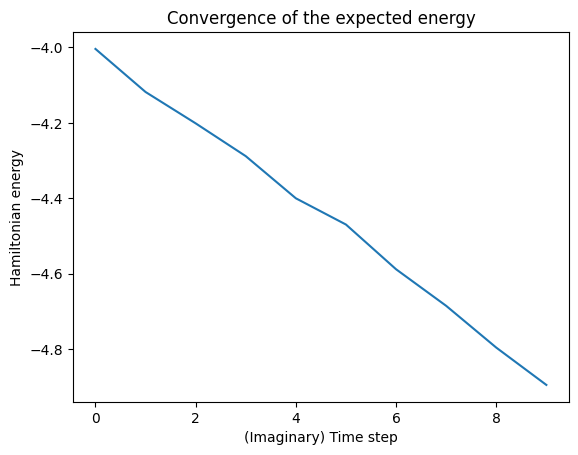

In [8]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# Build the MaxCut Hamiltonian
# H = (|E|/2) I - (1/2) Σ Z_i Z_j for each friendship (edge)
def build_maxcut_hamiltonian(graph: nx.Graph) -> SparsePauliOp:
    num_qubits = graph.number_of_nodes()
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I" * num_qubits]
    coeffs = [-num_edges / 2]
    for (u, v) in edges:
        term = ["I"] * num_qubits
        term[u], term[v] = "Z", "Z"
        pauli_terms.append("".join(term))
        coeffs.append(0.5)
    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

# Assemble and run varQITE evolver
ham = build_maxcut_hamiltonian(graph)
qit_evolver = QITEvolver(ham, ansatz)
# Wander through 10 Wonder Realm steps at learning rate 0.1
qit_evolver.evolve(num_steps=10, lr=0.1, verbose=True)
# Visualize convergence of Puzzle Power
qit_evolver.plot_convergence()

At last, the moment arrives! The wizards gather in the sun-drenched hall, eyes bright with anticipation as they channel their collective wisdom through the quantum circuit. Qubits reveal their states; each outcome shows a different possible arrangement of friendships:

In [9]:
from qiskit_aer import AerSimulator

shots = 100_000
backend = AerSimulator()
# Bind the final optimized parameters
optimized_state = ansatz.assign_parameters(qit_evolver.param_vals[-1])
optimized_state.measure_all()
# Run and collect bitstring counts
counts = backend.run(optimized_state, shots=shots).result().get_counts()
print(counts)

{'11110011': 106, '01111110': 134, '00000000': 38, '00001110': 97, '10000000': 104, '01111100': 110, '00000011': 109, '00011000': 107, '00000100': 96, '11110000': 135, '11011001': 278, '00111000': 92, '11111101': 104, '01001100': 337, '01100001': 335, '00101110': 287, '01111000': 120, '10110001': 313, '00100100': 266, '00000110': 87, '01001111': 299, '10010111': 308, '00110110': 276, '11011100': 331, '01100111': 289, '11001000': 315, '00100001': 314, '11001111': 89, '10001011': 305, '11111110': 130, '00011110': 112, '00100110': 267, '00001010': 286, '10101111': 315, '10010001': 307, '01110011': 295, '11010111': 261, '00010100': 263, '11000011': 119, '00110000': 109, '11011011': 294, '00110111': 336, '00010001': 333, '11000001': 110, '01000100': 307, '11101001': 264, '11100111': 102, '10100110': 822, '01000111': 291, '00011001': 300, '11111010': 330, '11011101': 289, '10011100': 278, '01111111': 118, '11000101': 271, '11000000': 106, '11010011': 278, '11001100': 336, '00000001': 104, '0



---



## Chapter IV – Discoveries Revealed

*(Histogram of Cuts)*

By daylight, the wizards sketch a colorful chart. Bars rise like playful fountains, each representing the number of friendship groups discovered in a single casting. The tallest bar shines brightest—the most common pattern of connections.

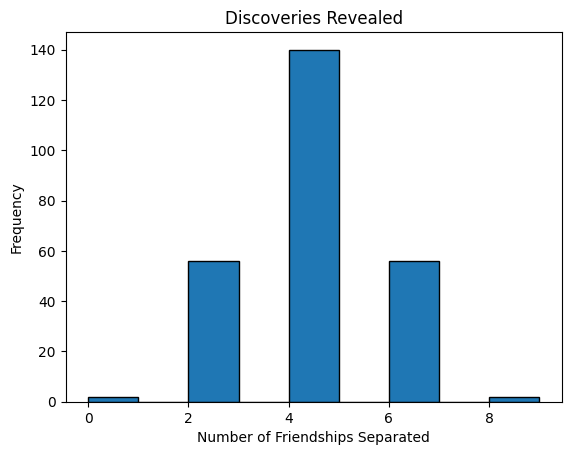

In [10]:
def compute_cut_size(graph, bitstring):
    cut_sz = 0
    for (u, v) in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_sz += 1
    return cut_sz

# Convert counts to cut sizes
group_counts = [compute_cut_size(graph, bs) for bs in counts]

# Plot discoveries
import matplotlib.pyplot as plt
plt.hist(group_counts, bins=range(len(graph.edges)+2), edgecolor='black')
plt.xlabel('Number of Friendships Separated')
plt.ylabel('Frequency')
plt.title('Discoveries Revealed')
plt.show()

## Understanding the Discoveries

The histogram above reveals how many friendships are severed by each sampled bitstring.

* The x-axis shows the Number of Friendships Separated in a single casting.

* The y-axis shows Frequency: how often each cut size appeared in our 100,000-shot experiment.

On a Cycle Graph of 8 nodes (our Atlas), the maximum possible cut severs all 8 edges, corresponding to two alternating groups of friends. In practice, we see most samples produce 4 or 6 cuts, with fewer reaching the perfect 8 or the trivial 0.

This distribution tells us:

* Near-Optimal Solutions: A sizable fraction of bitstrings achieve 6 cuts—close to the ideal—indicating our ansatz and varQITE have steered the state toward high-quality partitions.

* Mid-Energy Peaks: The large peak at 4 cuts reflects the many mid-level energy states available on this graph; these are easier to reach with limited ansatz depth.

* Rare Extremes: Perfect cuts (8) and trivial cuts (0) are rare, showing that finding the absolute ground state remains challenging without deeper circuits or more optimization steps.

By relating these results back to our original Atlas, we see quantum imaginary-time evolution biasing the sampling toward low-energy (high-cut) configurations—bringing us “full circle”!



---



## Epilogue

You close the Book of Quantum Puzzles with an enthusiastic invitation: try different Wonder Realm step sizes, experiment with the number of iterations, and redesign your quantum circuit.

To sum it all up, the Variational Quantum Imaginary Time Evolution (**varQITE**) algorithm works by:

1. Starting Point: A parameterized quantum circuit (our "Puzzle Spell").

2. Imaginary Time: Evolving the system in small steps Δτ (our "Wonder Realm").

3. Optimization: Solving linear equations to update parameters and minimize energy (or maximize "Puzzle Power").

4. Convergence: Approaching the ground state, revealing optimal cuts in the friendship network.

Thus concludes our journey through magical puzzles and quantum algorithm design. May your future quantum explorations be as enlightening as they are entertaining!



---



# Building Intuition for Max Cut Hamiltonian

In [11]:
def format_hamiltonian(ham: SparsePauliOp):
    terms = []
    for pauli, coeff in ham.label_iter():
        if np.isclose(coeff.imag, 0):
             coeff_str = f"{coeff.real:+.1f}"
        else:
             coeff_str = f"({coeff.real:+.1f}{coeff.imag:+.1f}j)"
        terms.append(f"{coeff_str} * {pauli}")
    return "\n".join(terms)

## Understanding the MaxCut Hamiltonian

To build intuition about how the MaxCut objective function translates into a Hamiltonian, let's look at how it's constructed for graphs of increasing size. The Hamiltonian formulation allows us to find the maximum cut by finding the ground state (minimum energy state) of the Hamiltonian.

Recall the MaxCut Hamiltonian formulation used:
$$H_M = \sum_{(i,j) \in E} \frac{1}{2}(I - Z_i Z_j) = \frac{1}{2}|E|I - \frac{1}{2} \sum_{(i,j) \in E} Z_i Z_j$$
Here, $Z_i$ represents the Pauli-Z operator acting on the qubit corresponding to node $i$. Minimizing the energy of $H_M$ maximizes the sum of $Z_i Z_j$ terms for connected nodes, which happens when $Z_i$ and $Z_j$ have opposite eigenvalues (+1 and -1), corresponding to nodes $i$ and $j$ being in different partitions (i.e., the edge $(i,j)$ is cut).

The Hamiltonian consists of two parts:
1.  A constant energy shift term: $\frac{|E|}{2} I$, where $|E|$ is the number of edges. This term shifts the overall energy but doesn't affect which state is the ground state. In the `SparsePauliOp` representation below, this corresponds to the coefficient of the Identity (`I...I`) term (note the sign difference in the code implementation: it uses $-|E|/2$).
2.  Interaction terms: $-\frac{1}{2} Z_i Z_j$ for each edge $(i, j)$ in the graph. These terms penalize connected nodes being in the same partition set. In the `SparsePauliOp`, these correspond to the terms with two Z's and a coefficient of $+0.5$ (again, sign differs from the sum formula due to implementation details, but the physics of minimizing the Hamiltonian remains equivalent to maximizing the cut).

Let's see how this looks for small graphs:

### 3 Vertices

3 Vertices (Triangle K3)
Nodes: 3, Edges: 3
Edges: [(0, 1), (0, 2), (1, 2)]

Hamiltonian terms:
-1.5 * III
+0.5 * ZZI
+0.5 * ZIZ
+0.5 * IZZ


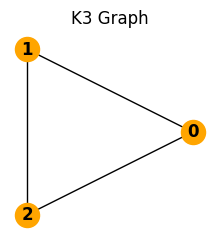

In [12]:
# 3 Vertices (Triangle K3)
G3 = nx.complete_graph(3)
n3 = G3.number_of_nodes()
m3 = G3.number_of_edges()
ham3 = build_maxcut_hamiltonian(G3)

print(f"3 Vertices (Triangle K3)")
print(f"Nodes: {n3}, Edges: {m3}")
print(f"Edges: {list(G3.edges())}")
print("\nHamiltonian terms:")
print(format_hamiltonian(ham3))

plt.figure(figsize=(2,2))
nx.draw_circular(G3, with_labels=True, node_color='orange', font_weight='bold')
plt.title("K3 Graph")
plt.show()

* **Graph:** A complete graph on 3 nodes (0, 1, 2).
* **Nodes (n):** 3
* **Edges (m):** 3, connecting (0,1), (0,2), and (1,2), as shown in the plot above.
* **Hamiltonian:** $H_M = \frac{3}{2}I - \frac{1}{2} (Z_0 Z_1 + Z_0 Z_2 + Z_1 Z_2)$
* **Output Terms:**
    * `-1.5 * III`: This is the constant term $-\frac{|E|}{2}I = -\frac{3}{2}I$.
    * `+0.5 * ZZI`: Represents the interaction for edge (0,1).
    * `+0.5 * ZIZ`: Represents the interaction for edge (0,2).
    * `+0.5 * IZZ`: Represents the interaction for edge (1,2).

Minimizing the energy of this Hamiltonian encourages adjacent qubits (representing connected nodes) to have opposite Z-measurement outcomes (different partitions).

### 4 Vertices

4 Vertices (Square C4)
Nodes: 4, Edges: 4
Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]

Hamiltonian terms:
-2.0 * IIII
+0.5 * ZZII
+0.5 * ZIIZ
+0.5 * IZZI
+0.5 * IIZZ


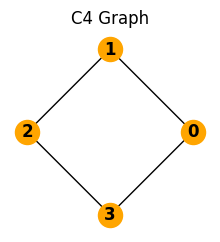

In [13]:
# 4 Vertices (Square C4)
G4 = nx.cycle_graph(4)
n4 = G4.number_of_nodes()
m4 = G4.number_of_edges()
ham4 = build_maxcut_hamiltonian(G4)

print(f"4 Vertices (Square C4)")
print(f"Nodes: {n4}, Edges: {m4}")
print(f"Edges: {list(G4.edges())}")
print("\nHamiltonian terms:")
print(format_hamiltonian(ham4))

plt.figure(figsize=(2,2))
nx.draw_circular(G4, with_labels=True, node_color='orange', font_weight='bold')
plt.title("C4 Graph")
plt.show()

* **Graph:** A cycle graph on 4 nodes (0, 1, 2, 3).
* **Nodes (n):** 4
* **Edges (m):** 4, connecting (0,1), (1,2), (2,3), and (3,0).
* **Hamiltonian:** $H_M = \frac{4}{2}I - \frac{1}{2} (Z_0 Z_1 + Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_0)$
* **Output Terms:**
    * `-2.0 * IIII`: The constant term $-\frac{|E|}{2}I = -\frac{4}{2}I$.
    * `+0.5 * ZZII`: Interaction for edge (0,1).
    * `+0.5 * IZZI`: Interaction for edge (1,2).
    * `+0.5 * IIZZ`: Interaction for edge (2,3).
    * `+0.5 * ZIIZ`: Interaction for edge (3,0).

### 5-Vertex Graph

5 Vertices (Cycle C5)
Nodes: 5, Edges: 5
Edges: [(0, 1), (0, 4), (1, 2), (2, 3), (3, 4)]

Hamiltonian terms:
-2.5 * IIIII
+0.5 * ZZIII
+0.5 * ZIIIZ
+0.5 * IZZII
+0.5 * IIZZI
+0.5 * IIIZZ


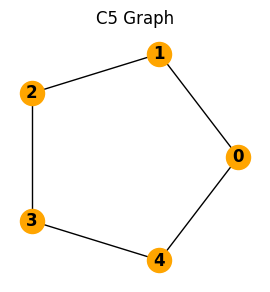

In [14]:
# 5 Vertices (Cycle C5)
G5 = nx.cycle_graph(5)
n5 = G5.number_of_nodes()
m5 = G5.number_of_edges()
ham5 = build_maxcut_hamiltonian(G5)

print(f"5 Vertices (Cycle C5)")
print(f"Nodes: {n5}, Edges: {m5}")
print(f"Edges: {list(G5.edges())}")
print("\nHamiltonian terms:")
print(format_hamiltonian(ham5))

plt.figure(figsize=(2.5,2.5))
nx.draw_circular(G5, with_labels=True, node_color='orange', font_weight='bold')
plt.title("C5 Graph")
plt.show()

* **Graph:** A cycle graph on 5 nodes (0, 1, 2, 3, 4).
* **Nodes (n):** 5
* **Edges (m):** 5, connecting (0,1), (1,2), (2,3), (3,4), and (4,0).
* **Hamiltonian:** $H_M = \frac{5}{2}I - \frac{1}{2} (Z_0 Z_1 + Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4 + Z_4 Z_0)$
* **Output Terms:**
    * `-2.5 * IIIII`: The constant term $-\frac{|E|}{2}I = -\frac{5}{2}I$.
    * `+0.5 * ZZIII`: Interaction for edge (0,1).
    * `+0.5 * IZZII`: Interaction for edge (1,2).
    * `+0.5 * IIZZI`: Interaction for edge (2,3).
    * `+0.5 * IIIZZ`: Interaction for edge (3,4).
    * `+0.5 * ZIIIZ`: Interaction for edge (4,0).

### 6-Vertex Sparce Graph

--- 6 Vertices (Sparse - Path P6) ---
Nodes: 6, Edges: 5
Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

Hamiltonian terms:
-2.5 * IIIIII
+0.5 * ZZIIII
+0.5 * IZZIII
+0.5 * IIZZII
+0.5 * IIIZZI
+0.5 * IIIIZZ


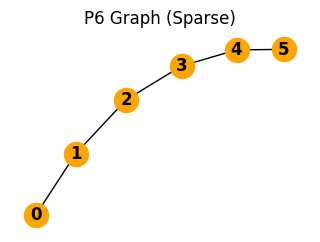

In [15]:
# 6 Vertices (Sparse - Path P6)
G6_sparse = nx.path_graph(6)
n6s = G6_sparse.number_of_nodes()
m6s = G6_sparse.number_of_edges()
ham6s = build_maxcut_hamiltonian(G6_sparse)

print(f"--- 6 Vertices (Sparse - Path P6) ---")
print(f"Nodes: {n6s}, Edges: {m6s}")
print(f"Edges: {list(G6_sparse.edges())}")
print("\nHamiltonian terms:")
print(format_hamiltonian(ham6s))

plt.figure(figsize=(3,2))
nx.draw(G6_sparse, with_labels=True, node_color='orange', font_weight='bold')
plt.title("P6 Graph (Sparse)")
plt.show()

* **Graph:** A path graph on 6 nodes (0 to 5). This is a sparse graph (edges = nodes - 1).
* **Nodes (n):** 6
* **Edges (m):** 5, connecting (0,1), (1,2), (2,3), (3,4), and (4,5).
* **Hamiltonian:** $H_M = \frac{5}{2}I - \frac{1}{2} (Z_0 Z_1 + Z_1 Z_2 + Z_2 Z_3 + Z_3 Z_4 + Z_4 Z_5)$
* **Output Terms:**
    * `-2.5 * IIIIII`: The constant term $-\frac{|E|}{2}I = -\frac{5}{2}I$.
    * `+0.5 * ZZIIII`: Interaction for edge (0,1).
    * `+0.5 * IZZIII`: Interaction for edge (1,2).
    * `+0.5 * IIZZII`: Interaction for edge (2,3).
    * `+0.5 * IIIZZI`: Interaction for edge (3,4).
    * `+0.5 * IIIIZZ`: Interaction for edge (4,5).

Notice how the structure directly follows the path connections.

### 6-Vertex Dense Graph

--- 6 Vertices (Dense - Complete K6) ---
Nodes: 6, Edges: 15
Edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]

Hamiltonian terms:
-7.5 * IIIIII
+0.5 * ZZIIII
+0.5 * ZIZIII
+0.5 * ZIIZII
+0.5 * ZIIIZI
+0.5 * ZIIIIZ
+0.5 * IZZIII
+0.5 * IZIZII
+0.5 * IZIIZI
+0.5 * IZIIIZ
+0.5 * IIZZII
+0.5 * IIZIZI
+0.5 * IIZIIZ
+0.5 * IIIZZI
+0.5 * IIIZIZ
+0.5 * IIIIZZ


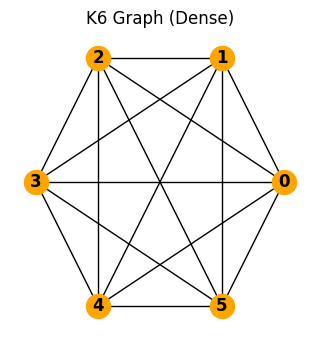

In [16]:
# 6 Vertices (Dense - Complete K6)
G6_dense = nx.complete_graph(6)
n6d = G6_dense.number_of_nodes()
m6d = G6_dense.number_of_edges()
ham6d = build_maxcut_hamiltonian(G6_dense)

print(f"--- 6 Vertices (Dense - Complete K6) ---")
print(f"Nodes: {n6d}, Edges: {m6d}")
print(f"Edges: {list(G6_dense.edges())}")
print("\nHamiltonian terms:")
print(format_hamiltonian(ham6d))

plt.figure(figsize=(3,3))
nx.draw_circular(G6_dense, with_labels=True, node_color='orange', font_weight='bold')
plt.title("K6 Graph (Dense)")
plt.show()

* **Graph:** A complete graph on 6 nodes (0 to 5). This is a dense graph (edges = n*(n-1)/2).
* **Nodes (n):** 6
* **Edges (m):** 15 (connecting every distinct pair of nodes).
* **Hamiltonian:** $H_M = \frac{15}{2}I - \frac{1}{2} \sum_{0 \le i < j \le 5} Z_i Z_j$
* **Output Terms:**
    * `-7.5 * IIIIII`: The constant term $-\frac{|E|}{2}I = -\frac{15}{2}I$.
    * **15 terms** of the form `+0.5 * ...ZZ...`: One term for each edge, representing the interaction between the connected pair of nodes (e.g., `ZZIIII` for edge (0,1), `ZIZIII` for edge (0,2), ..., `IIIIZZ` for edge (4,5)).

As the graph becomes denser, the number of $Z_i Z_j$ interaction terms in the Hamiltonian increases significantly, matching the number of edges. This reflects the increased complexity of finding the maximum cut in a highly connected graph.

Now, you can take these graphs and replace with them the one from the Chapter I, and try to experiment with it. Good luck, apprentices!